# Segmenting overlapping parts of a chromosome

In this project, we designed a U-net to detect the overlapping part of a chromosome database obtained from Kaggle.

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

#h5f = h5py.File('overlapping_chromosomes_examples.h5','r')
h5f = h5py.File('LowRes_13434_overlapping_pairs.h5','r')
pairs = h5f['dataset_1'][:]
h5f.close()
pairs.shape

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(13434, 94, 93, 2)

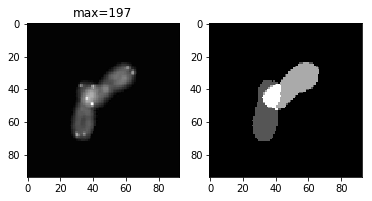

In [2]:
grey = pairs[1521,:,:,0]
mask = pairs[1521,:,:,1]
%matplotlib inline
plt.subplot(121)
plt.imshow(grey,cmap='gray')
plt.title('max='+str(grey.max()))
plt.subplot(122)
plt.imshow(mask,cmap='gray')


In [3]:
pairs[1,:,:,0].shape

(94, 93)

In [4]:
import scipy.misc as scipyMis 

resampledGrey=[]
resampledMask=[]
#for i in range(100):
for i in range(pairs.shape[0]):
    resampledGrey += [scipyMis.imresize(pairs[i,:,:,0],[48,48],'nearest')]
    resampledMask += [scipyMis.imresize(pairs[i,:,:,1],[48,48],'nearest')]

/home/sara/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/sara/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [5]:
del pairs

In [6]:
np.array(resampledGrey).shape
np.max(resampledMask[0])
a=np.unique(np.array(resampledMask[0]/85).astype(int)).flatten()
print(a)

[0 1 2 3]


In [7]:
xtrain = np.array(resampledGrey)/255.0
ytrain = (np.array(resampledMask)/85).astype(int)

In [8]:
xtrain=np.expand_dims(xtrain,axis=-1)
ytrain=np.reshape(ytrain,(13434,2304,-1))
ytrain.shape
#13434

(13434, 2304, 1)

In [9]:
#ytrain=np.expand_dims(ytrain,axis=-1)
#ytrain.shape


In [10]:
#from keras.utils import to_categorical
#ytrain = to_categorical(ytrain,4)

In [11]:
#ytrain = np.reshape(ytrain,(100, 48*48,-1))

In [ ]:
from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.optimizers import *


inputs = Input((48, 48,1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv5), conv4])
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv6), conv3])
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv7), conv2])
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = Concatenate(axis=-1)([UpSampling2D((2,2))(conv8), conv1])
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(4, (1, 1))(conv9)
conv11 = Reshape((-1, 4))(conv10)
conv12 = Activation('softmax')(conv11)
print(conv12)

model = Model(input=[inputs], output=[conv12])
model.compile(optimizer=Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Tensor("activation_1/truediv:0", shape=(?, ?, 4), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/sara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 48, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 24, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
model.fit(xtrain,ytrain,validation_split=0.3)

Train on 9403 samples, validate on 4031 samples
Epoch 1/1
2976/9403 [========>.....................] - ETA: 1:05:55 - loss: 1.2053 - acc: 0.8417